[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/SatelliteVu/SatelliteVu-AWS-Disaster-Response-Hackathon/blob/main/classical_ml/create_csv.ipynb)

Classical ML models were trained on flattened 3x3 pixel patches of imagery. This required transforming the dataset of images to a table of data in csv format, demonstrated in this notebook.

- numpy-1.22.1 required for `np.lib.stride_tricks.sliding_window_view`
- Note we reject the outermost pixels using a kernel of 3 x 3
- each 64x64 image therefore contributes 62*62 = 3844 rows

In [1]:
from tqdm import tqdm
import pandas as pd
import s3fs
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from multiprocessing.pool import ThreadPool 
import os

import matplotlib.pyplot as plt
from matplotlib import colors

def extract_kernel_df(image_arr: np.array, feature: str = "default", kernel: int = 3) -> pd.DataFrame:
    """
    Function which takes a 2d image array, applies a kernel 
    to each pixel, and returns a dataframe where each row is the kernel for a single pixel
    and each col is a location on the kernel.
    """
    strided = np.lib.stride_tricks.sliding_window_view(image_arr, (kernel, kernel))
    strided_reshaped = strided.reshape(strided.shape[0]*strided.shape[1], kernel*kernel) # flatten the kernel and a row for each pixel
    columns = [f"{feature}_{i}" for i in range(kernel*kernel)]
    return pd.DataFrame(data = strided_reshaped, columns = columns)

In [2]:
fs = s3fs.S3FileSystem()

Get features available from a single example

In [3]:
features = fs.glob('satvu-derived-data/hackathon_data/samples/0/*.npy')
features = [f.split('/')[-1].split('.')[0] for f in features]
features.remove('sea_surface_temperature')
features

['air_pressure_at_mean_sea_level',
 'air_temperature_at_2_metres',
 'air_temperature_at_2_metres_1hour_Maximum',
 'air_temperature_at_2_metres_1hour_Minimum',
 'dew_point_temperature_at_2_metres',
 'eastward_wind_at_100_metres',
 'eastward_wind_at_10_metres',
 'elevation',
 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation',
 'landcover',
 'lwe_thickness_of_surface_snow_amount',
 'ndvi',
 'northward_wind_at_100_metres',
 'northward_wind_at_10_metres',
 'precipitation_amount_1hour_Accumulation',
 'snow_density',
 'surface_air_pressure',
 'todays_fires',
 'todays_frp',
 'tomorrows_fires',
 'tomorrows_frp']

In [4]:
# or manually curate

features = [
    'todays_frp',
    'elevation',
    'landcover',
    'todays_fires',
    'tomorrows_fires',
]

Samples are split into train/test/eval in a csv, for consistent comparison with the deep learning model.

In [5]:
splits_df = pd.read_csv('splits.csv')

splits_df.head()

,sample_id,class
0,0,train
1,1,train
2,2,train
3,3,train
4,4,train


In [8]:

sample_ids = splits_df['sample_id'].unique()
len(sample_ids)

15435

Now loop to extract data from s3 to local dataframe

In [10]:
# multi thread - kernel extract
def get_data_for_sample(id: int) -> pd.DataFrame:
    feature_df_list = [] # keep features df in list
    for feature in features:
        img_arr = np.load(fs.open(f's3://satvu-derived-data/hackathon_data/samples/{id}/{feature}.npy'))
        if feature == 'tomorrows_fires': # our target, dont need kernel
            img_arr = img_arr[1:-1, 1:-1] # strip outer pixels
            feature_df = pd.DataFrame(data = img_arr.flatten(), columns = ['tomorrows_fires'])
        else: # all features we use kernel
            feature_df = extract_kernel_df(img_arr, feature)
        feature_df_list.append(feature_df) # append features
    feature_df_list.append(pd.DataFrame(data = np.ones(62*62)*int(id), columns = ['image_index'])) # append features
    return pd.concat(feature_df_list, axis=1)

In [11]:
%%time

with ThreadPool(os.cpu_count()) as pool:
      results = list(tqdm(pool.imap(get_data_for_sample, sample_ids), total=len(sample_ids)))
    
len(results)

df = pd.concat(results, axis=0)
df.to_csv('data.csv', index=False)
df.shape

100%|██████████| 15435/15435 [27:21<00:00,  9.40it/s] 


CPU times: user 28min 34s, sys: 1min 5s, total: 29min 40s
Wall time: 49min 40s


(59339670, 38)

static_fire_pixels: 0.0
fire_ave_size: 23.0
percent static: 0.0 %


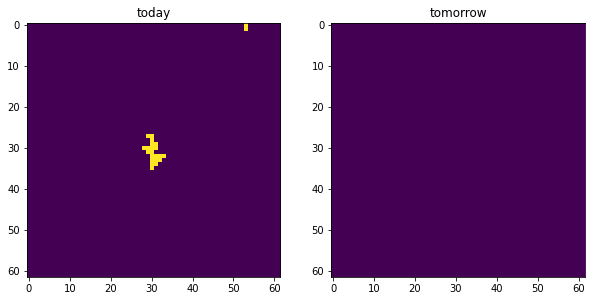

In [15]:
def plot_feature(image_index: int):
    frame_size = 62*62
    start_index = image_index*frame_size
    end_index = (image_index+1)*frame_size
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    today = df["todays_fires_4"].iloc[start_index:end_index].values.reshape(62, 62)
    tomorrow = df["tomorrows_fires"].iloc[start_index:end_index].values.reshape(62, 62)
    ax1.imshow(today)
    ax1.set_title("today")
    ax2.imshow(tomorrow)
    ax2.set_title("tomorrow")
    static_fire_pixels = np.sum(today.flatten()*tomorrow.flatten())
    print(f"static_fire_pixels: {static_fire_pixels}")
    fire_ave_size = np.mean(today.flatten().sum() + tomorrow.flatten().sum())
    print(f"fire_ave_size: {fire_ave_size}")
    print(f"percent static: {round(100*static_fire_pixels/fire_ave_size, 1)} %")
    
image_index = 5
plot_feature(image_index)